# Image Captioning

Image Captioning on Flickr8k Dataset

The following is the code of the model that generates captions for a Image.

InceptionNetV3 is used to Feature Extraction.

## Importing Libraries and Dataset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
import os
import ast
import scipy
import pandas as pd
from pickle import dump, load
import keras
import random
import string
import cv2,re
from skimage.io import imread, imshow, imread_collection, concatenate_images
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Add, Input, Flatten,Embedding,LSTM,GlobalAveragePooling2D,Concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3
from skimage.transform import resize
from skimage.io import imsave
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Learning and Developing/Datasets/Flickr_Data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Learning and Developing/Datasets/Flickr_Data


## Importing Images and Captions

Generating a List of Available Images

In [0]:
base_dir = os.getcwd()
os.chdir(base_dir+'/Images')
Available_Images = os.listdir()
os.chdir(base_dir)

Importing Captions

In [0]:
filename = 'Flickr_TextData/Flickr8k.token.txt'
file = open(filename,'r')
Data = file.read()

## Loading and Preprocessing Data

Function to Preprocess Captions/Text

In [0]:
def PreprocessingCaptions(text):
    
    # Removing Punctions
    translator = str.maketrans('', '', string.punctuation)
    text.translate(translator)

    # Converting in Lower Characters
    text = re.sub("[^a-zA-Z]"," ",text)
    text = [word.lower() for word in text.split()]

    # Removing Hanging Letters
    text = [word for word in text if len(word)>1]
    
    text = " ".join(text)
    
    return text

Function to Create a Map Between Images and Captions

In [0]:
def LoadData(data,Available_Images):
    Image2Caption = {}

    MaxLength = 0

    for line in data.split('\n'):
        l = line.split()
        if len(l) < 2:
            continue
        ImageName, Caption = l[0], l[1:]
        ImageName = ImageName.split('#')[0]

        if  ImageName in Available_Images:
            Caption = ' '.join(Caption)
            Caption = 'startsqn ' + PreprocessingCaptions(Caption) + ' endsqn'

            length = len(Caption.split())
            MaxLength = max(MaxLength,length)

            if ImageName not in Image2Caption:
                Image2Caption[ImageName] = []

            Image2Caption[ImageName].append(Caption)

    return Image2Caption,MaxLength

Image2Caption,MaxLength = LoadData(Data,Available_Images)

Train and Test Split

In [0]:
def TrainTestSplit(Image2Caption):
    base = os.getcwd()
    os.chdir(base+'/Flickr_TextData')
    filename = 'Flickr_8k.trainImages.txt'
    file = open(filename,'r')
    TrainData = file.read()

    os.chdir(base+'/Flickr_TextData')
    filename = 'Flickr_8k.devImages.txt'
    file = open(filename,'r')
    DevData = file.read()

    os.chdir(base+'/Flickr_TextData')
    filename = 'Flickr_8k.testImages.txt'
    file = open(filename,'r')
    TestData = file.read()

    os.chdir(base)

    Train = {}
    Dev = {}
    Test = {}

    for line in TrainData.split('\n'):
        ImageName = line.split('.')[0]
        ImageName = ImageName+'.jpg'
        if ImageName in list(Image2Caption.keys()):
            Train[ImageName] = Image2Caption[ImageName]
            del Image2Caption[ImageName]

    for line in DevData.split('\n'):
        ImageName = line.split('.')[0]
        ImageName = ImageName+'.jpg'
        if ImageName in list(Image2Caption.keys()):
            Dev[ImageName] = Image2Caption[ImageName]
            del Image2Caption[ImageName]

    for line in TestData.split('\n'):
        ImageName = line.split('.')[0]
        ImageName = ImageName+'.jpg'
        if ImageName in list(Image2Caption.keys()):
            Test[ImageName] = Image2Caption[ImageName]
            del Image2Caption[ImageName]

    return Train,Dev,Test

In [0]:
Train,Dev,Test = TrainTestSplit(Image2Caption)

## InceptionNetV3

We will use InceptionNetV3 to get fixed-length informative vector for each image. This process is called Automatic Feature Engineering.

![Feature Extraction](https://iust-projects.ir/assets/images/projects/dip/10/wiki/3_2.png)

Removing Softmax Layer from the Model

In [0]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 2s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
FeatureExtractionModel = Model(model.input, model.layers[-2].output)

To ge the summary and Plot Model use the following lines:


```
FeatureExtractionModel.summary()
plot_model(FeatureExtractionModel, to_file='Feature_Extraction_Part_of_InceptionNetV3.png')
```



## Preprocessing and Encoding Image Data

Preprocessing Image for InceptionNetV3

In [0]:
def ExtractImage(Image_Name):
    filename = 'Images/' + Image_Name
    img = FeatureExtractionModel.predict(resize(imread(filename),(1,299,299,3)))
    img = img.flatten()
    
    return img

In [0]:
def SaveEncoded(Dataset,name):
    ImageData = Dataset.keys()

    Encode = {}
    i = 0
    for img in ImageData:
        Encode[img] = ExtractImage(img)
        i+=1
        if i%10 == 0:
            print (str(i)+' Images Encoded')
    
    filename = name
    outputfile = open(filename,'wb')
    dump(Encode,outputfile)
    outputfile.close()

Run this Code to save Data
```
SaveEncoded(Train,'TrainData')
print ("Saved Train Data")

SaveEncoded(Dev,'DevData')
print ("Saved Dev Data")

SaveEncoded(Test,'TestData')
print ("Saved Test Data")
```


In [0]:
TrainFeatures = load(open('TrainData','rb'))
DevFeatures = load(open('DevData','rb'))

## Preprocessing Captions

Extracting all Captions

In [0]:
def ExtractAllCaptions(Image2Caption):
    AllCaptions = []
    for key,val in Image2Caption.items():
        for cap in val:
            AllCaptions.append(cap)

    return AllCaptions

Image2Caption = {**Train,**Dev,**Test}
AllCaptions = ExtractAllCaptions(Train)

Extract Words and Words above Threshold

In [0]:
def ThresholdandVocab(AllCaptions,Threshold=10):
    Word_Count = {}
    for cap in AllCaptions:
        for w in cap.split(" "):
            Word_Count[w] = Word_Count.get(w,0) + 1

    Vocab = list(Word_Count.keys())
    ThVocab = []
    for key,val in Word_Count.items():
        if val >=10:
            ThVocab.append(key)

    return ThVocab,Vocab

ThVocab,Vocab = ThresholdandVocab(AllCaptions,Threshold=10)

Mapping Word2Index and Index2Word

In [0]:
def Mapping(ThVocab):
    index = 1
    Word2Index = {}
    Index2Word = {}

    for w in ThVocab:
        Word2Index[w] = index
        Index2Word[index] = w
        index += 1
    
    return Word2Index,Index2Word

Word2Index,Index2Word = Mapping(ThVocab)
VocabSize = len(Word2Index) + 1

In [0]:
VocabSize,MaxLength

(1657, 35)

## GloVe Vectors

GloVe is an unsupervised learning algorithm for obtaining vector representations for words.

In [0]:
def GloVeEmbeddings():
    base = os.getcwd()
    os.chdir(base+'/glove.6B.200d')
    GloVe = open('glove.6B.200d.txt', encoding="utf-8")

    Embeddings = {}

    for line in GloVe:
        data = line.split()
        word = data[0]
        coeffmatrix = np.asarray(data[1:],dtype='float32')
        Embeddings[word] = coeffmatrix

    GloVe.close()
    os.chdir(base)

    return Embeddings

Embeddings = GloVeEmbeddings()

In [0]:
def WordEmbeddings(Word2Index,VocabSize):
    Embedding_Dims = 200
    Embedding_Matrix = np.zeros((VocabSize,Embedding_Dims))
    
    for word,idx in Word2Index.items():
        Embedding_Vector = Embeddings.get(word)
        if Embedding_Vector is not None:
            Embedding_Matrix[idx] = Embedding_Vector

    return Embedding_Matrix

Embedding_Matrix = WordEmbeddings(Word2Index,VocabSize)

In [0]:
Embedding_Matrix.shape

(1657, 200)

## Creating Model

In [0]:
tf.keras.backend.clear_session()
Input1 = tf.keras.Input(shape=(2048,),dtype='float32',name='main_input')
a = tf.keras.layers.Dropout(0.5)(Input1)
a = tf.keras.layers.Dense(256, activation=tf.nn.relu)(a)
Input2 = tf.keras.Input(shape=(MaxLength,),name='aux_input')
b = tf.keras.layers.Embedding(VocabSize,200,mask_zero=True)(Input2)
b = tf.keras.layers.Dropout(0.5)(b)
b = tf.keras.layers.LSTM(256)(b)

c = tf.keras.layers.Add()([a,b])
c = tf.keras.layers.Dense(256,activation=tf.nn.relu)(c)
outputs = tf.keras.layers.Dense(VocabSize, activation=tf.nn.softmax)(c)
Model = tf.keras.Model(inputs=[Input1, Input2], outputs=outputs)

In [0]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aux_input (InputLayer)          [(None, 35)]         0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 200)      331400      aux_input[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           main_input[0][0]                 
______________________________________________________________________________________________

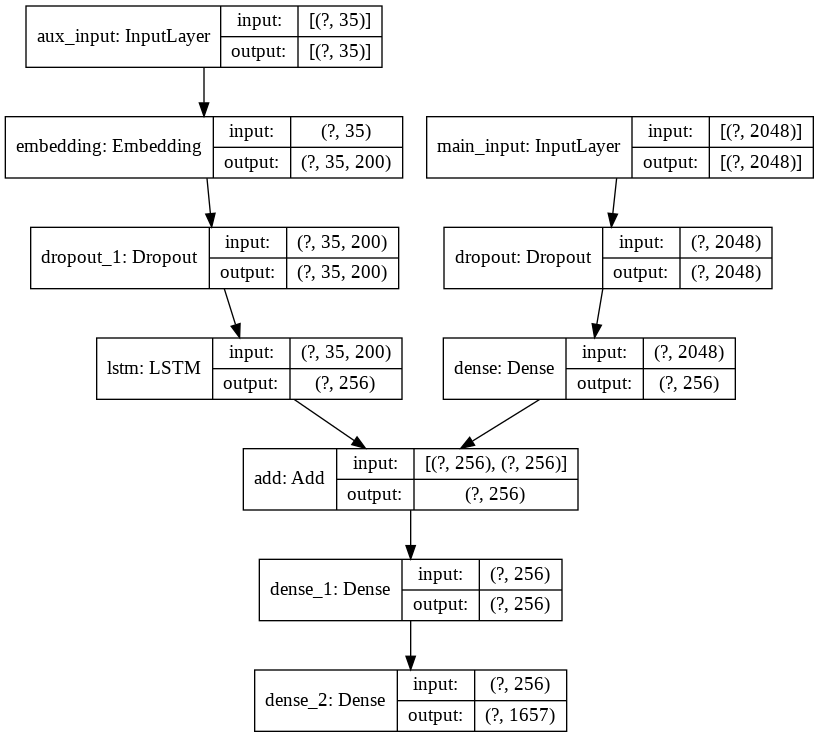

In [0]:
plot_model(Model, to_file='Caption_Generation_Model.png',show_shapes=True)

### Setting Model Weights

In [0]:
Model.layers[2]

In [0]:
Model.layers[2].set_weights([Embedding_Matrix])
Model.layers[2].trainable = False

In [0]:
Model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

## Dataset Generator

In [0]:
def DatasetGenerator(Dataset,Features,MaxLength,VocabSize):
    X1 = []
    X2 = []
    y = []
    n=0
    for name,captions in Dataset.items():
        feature = Features[name]
        n+=1
        for cap in captions:
            Encoded_Caption = [Word2Index[w] for w in cap.split(' ') if w in Word2Index]
            for i in range(1,len(Encoded_Caption)):
                InSeq, OutSeq = Encoded_Caption[:i], Encoded_Caption[i]
                # Padding Sequences
                # These Input Sequences will be passed through Embedding Layer
                InSeq = pad_sequences([InSeq], maxlen=MaxLength)[0]
                    
                # OneHot-Encoding Output Sequences
                OutSeq = to_categorical([OutSeq], num_classes=VocabSize)[0]
                X1.append(feature)
                X2.append(InSeq)
                y.append(OutSeq)

        if n%1000 == 0:
            print (str(n) + ' Images Completed')

    return np.array(X1),np.array(X2),np.array(y)

Train Dataset

In [0]:
X1_Train,X2_Train,y_Train = DatasetGenerator(Train,TrainFeatures,MaxLength,VocabSize)

1000 Images Completed
2000 Images Completed
3000 Images Completed
4000 Images Completed
5000 Images Completed
6000 Images Completed


Dev Dataset

In [0]:
X1_Dev,X2_Dev,y_Dev = DatasetGenerator(Dev,DevFeatures,MaxLength,VocabSize)

1000 Images Completed


## Training Model

In [0]:
Epochs = 40
Steps = 2000

Model.fit(x=[X1_Train,X2_Train],y=y_Train,epochs=Epochs,steps_per_epoch=Steps)
Model.save('Caption_Generator.h5')

Epoch 1/40
2000/2000 [==============================] - 260s 130ms/step - loss: 4.1022 - acc: 0.2386
Epoch 2/40
2000/2000 [==============================] - 261s 131ms/step - loss: 3.5122 - acc: 0.2840
Epoch 3/40
2000/2000 [==============================] - 262s 131ms/step - loss: 3.3321 - acc: 0.3000
Epoch 4/40
2000/2000 [==============================] - 260s 130ms/step - loss: 3.2189 - acc: 0.3102
Epoch 5/40
2000/2000 [==============================] - 260s 130ms/step - loss: 3.1362 - acc: 0.3176
Epoch 6/40
2000/2000 [==============================] - 262s 131ms/step - loss: 3.0683 - acc: 0.3233
Epoch 7/40
2000/2000 [==============================] - 259s 129ms/step - loss: 3.0165 - acc: 0.3260
Epoch 8/40
2000/2000 [==============================] - 245s 122ms/step - loss: 2.9680 - acc: 0.3312
Epoch 9/40
2000/2000 [==============================] - 258s 129ms/step - loss: 2.9244 - acc: 0.3352
Epoch 10/40
2000/2000 [==============================] - 259s 130ms/step - loss: 2.8913 - a

In [0]:
Epochs = 10
Steps = 1000
Model.optimizer.lr = 0.0001

Model.fit(x=[X1_Train,X2_Train],y=y_Train,epochs=Epochs,steps_per_epoch=Steps)
Model.save('Caption_Generator.h5')

Epoch 1/10
1000/1000 [==============================] - 133s 133ms/step - loss: 2.3970 - acc: 0.3987
Epoch 2/10
1000/1000 [==============================] - 134s 134ms/step - loss: 2.3665 - acc: 0.4042
Epoch 3/10
1000/1000 [==============================] - 134s 134ms/step - loss: 2.3536 - acc: 0.4067
Epoch 4/10
1000/1000 [==============================] - 133s 133ms/step - loss: 2.3454 - acc: 0.4085
Epoch 5/10
1000/1000 [==============================] - 133s 133ms/step - loss: 2.3370 - acc: 0.4096
Epoch 6/10
1000/1000 [==============================] - 126s 126ms/step - loss: 2.3326 - acc: 0.4113
Epoch 7/10
1000/1000 [==============================] - 124s 124ms/step - loss: 2.3265 - acc: 0.4111
Epoch 8/10
1000/1000 [==============================] - 124s 124ms/step - loss: 2.3217 - acc: 0.4124
Epoch 9/10
1000/1000 [==============================] - 125s 125ms/step - loss: 2.3165 - acc: 0.4127
Epoch 10/10
 980/1000 [============================>.] - 127s 129ms/step - loss: 2.3119 - a

## Testing

In [0]:
def Testing(ImagePath,FeatureExtractionModel,Model,Word2Index,Index2Word,MaxLength):
    Feature = FeatureExtractionModel.predict(resize(imread(ImagePath),(1,299,299,3)))
    InputText = 'startsqn'
    for i in range(MaxLength):
        Encoded = [Word2Index[w] for w in InputText.split() if w in Word2Index]
        Encoded = pad_sequences([Encoded],maxlen=MaxLength)
        Prediction = Model.predict([Feature,Encoded],verbose=0)
        Predict_Word = Index2Word[np.argmax(Prediction)]
        InputText += " " + Predict_Word
        if Predict_Word == 'endsqn':
            break

    Caption = InputText.split()    
    Caption = Caption[1:-1]
    Caption = ' '.join(Caption)

    plt.title(Caption)
    plt.imshow(imread(ImagePath))   
    plt.show()

    return Caption

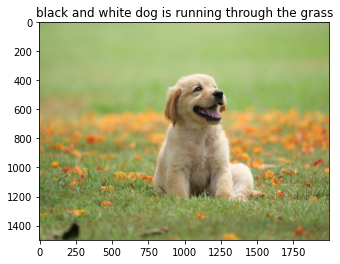

In [0]:
Caption = Testing('Dog.jpg',FeatureExtractionModel,Model,Word2Index,Index2Word,MaxLength)